In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
# %pip install gensim

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
# %pip install razdel
# %pip install pymorphy2
# %pip install --upgrade nltk
# import nltk
# nltk.download('stopwords')

In [7]:
#предобработка текстов
import re
import numpy as np

from nltk.corpus import stopwords

#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2  

In [8]:
stopword_ru = stopwords.words('russian')

len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [9]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 32.3 s, sys: 758 ms, total: 33.1 s
Wall time: 37.6 s


In [12]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 19s, sys: 4.4 s, total: 4min 24s
Wall time: 5min 15s


А теперь в 3 строчки обучим нашу модель

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [14]:
common_dictionary[10]

'ватутин'

Запускаем обучение

In [15]:
from gensim.models import LdaModel

In [16]:
# LdaModel?

In [41]:
topics_count = 32

In [42]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=topics_count, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 7s, sys: 1.83 s, total: 1min 8s
Wall time: 47.9 s


In [43]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [44]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.4173902),
 (11, 0.22214563),
 (18, 0.07403731),
 (29, 0.2157163),
 (31, 0.04834716)]

In [45]:
x=lda.show_topics(num_topics=topics_count, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: ребёнок возраст форум мужчина семья знаменитый больной
topic_1: средний министерство министр реформа сохранение годовой сенатор
topic_2: жертва тело произойти глава журналист местный инцидент
topic_3: рак мышь почва лечение заработок ричард мышца
topic_4: запустить журнал огонь км тепло явление рт
topic_5: россия российский сша nn американский глава исследование
topic_6: газ фонд писать риск агентство система газета
topic_7: греция фотография гарантия автобус сон болгария кровь
topic_8: военный космонавт боевой армия специальный советский оборона
topic_9: египет восток доля выделить бомба кремль сообщение
topic_10: рубль сотрудник уголовный задержать следствие страдать размер
topic_11: снижение энергия фестиваль супруг задать паника вечный
topic_12: станция житель столица мероприятие центр около праздник
topic_13: журнал взрыв иск виза вуз приостановить агентство
topic_14: nn километр конкурс университет первый день фильм
topic_15: проект новый развитие программа область прави

In [51]:
#text = news['title'].iloc[0]

def get_lda_vector(text, topics_count):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(topics_count):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [52]:
topic_matrix = pd.DataFrame([get_lda_vector(text, topics_count) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(topics_count)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(topics_count)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31
0,6,0.000000,0.0,0.0,0.069153,0.0,0.210024,0.000000,0.0,0.0,...,0.0,0.0,0.352351,0.0,0.0,0.0,0.0,0.000000,0.0,0.034111
1,4896,0.070927,0.0,0.0,0.266795,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,4897,0.000000,0.0,0.0,0.417366,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.215862,0.0,0.048322
3,4898,0.000000,0.0,0.0,0.151454,0.0,0.000000,0.070333,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.766836,0.0,0.000000
4,4899,0.000000,0.0,0.0,0.147638,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.332306,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


### Следующий шаг - векторные представления пользователей

In [53]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [54]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(topics_count)]].values))

In [203]:
doc_dict[6]

array([0.        , 0.        , 0.        , 0.06915307, 0.        ,
       0.21002367, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.31330153, 0.01328091, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3523508 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03411102])

In [232]:
# def get_user_embedding(user_articles_list):
#     user_articles_list = eval(user_articles_list)
#     user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.mean(user_vector, 0)
#     return user_vector

# Данные взяты из итога работы скрипта для данного варианта функции
# roc_auc (mean) = 0.9549628838596261
# Best Threshold=0.249144, F-Score=0.700, Precision=0.674, Recall=0.727


In [187]:
# РЕШЕНИЕ

# def get_user_embedding(user_articles_list):
#     user_articles_list = eval(user_articles_list)
#     user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.median(user_vector, 0)
#     return user_vector

# Данные взяты из итога работы скрипта для данного варианта функции
# # roc_auc (median) = 0.9828503295315968
# Best Threshold=0.259586, F-Score=0.825, Precision=0.788, Recall=0.866

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

# Данные взяты из итога работы скрипта для данного варианта функции
# roc_auc (max) = 0.9741895196961025
# Best Threshold=0.263731, F-Score=0.785, Precision=0.727, Recall=0.854


<table>
    <tr>
        <th></th>
        <th>roc_auc</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F-Score</th>
    </tr>
    <tr>
        <td><b>mean</b></td>
        <td>0.9549628838596261</td>
        <td>0.674</td>
        <td>0.727</td>
        <td>0.700</td>
    </tr>
    <tr>
        <td><b>median</b></td>
        <td>0.9828503295315968</td>
        <td>0.788</td>
        <td>0.866</td>
        <td>0.825</td>
    </tr>
    <tr>
        <td><b>max</b></td>
        <td>0.9741895196961025</td>
        <td>0.727</td>
        <td>0.854</td>
        <td>0.785</td>
    </tr>
</table>

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [219]:
users

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
...,...,...
7995,u107463,"[323918, 323362, 323704, 323452, 324291, 251]"
7996,u101241,"[5532, 5860, 7755, 7140, 5182, 488337]"
7997,u106486,"[322811, 323898, 321858, 323345, 323491, 2193]"
7998,u102220,"[5436, 6092, 6891, 7045, 5320, 487379]"


In [225]:
x = "[293672, 293328, 293001, 293622, 293126, 1852]"
get_user_embedding(x)

array([0.15708904, 0.02565975, 0.27123988, 0.03619965, 0.        ,
       0.19229947, 0.40085614, 0.        , 0.04763816, 0.13469069,
       0.08027549, 0.        , 0.25062746, 0.06083854, 0.1519132 ,
       0.28824228, 0.        , 0.        , 0.02206256, 0.        ,
       0.05172786, 0.09690372, 0.        , 0.        , 0.15290676,
       0.11557675, 0.21064155, 0.14634436, 0.        , 0.15751572,
       0.        , 0.58704746])

In [217]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
# user_embeddings.columns = ['topic_{}'.format(i) for i in range(topics_count)]
# user_embeddings['uid'] = users['uid'].values
# user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(topics_count)]]

In [218]:
user_embeddings

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.157089,0.025660,0.271240,0.036200,0.000000,0.192299,0.400856,0.000000,0.047638,0.134691,...,0.000000,0.000000,0.152907,0.115577,0.210642,0.146344,0.000000,0.157516,0.000000,0.587047
1,0.116260,0.010139,0.182481,0.000000,0.000000,0.348923,0.169945,0.000000,0.000000,0.014783,...,0.059782,0.000000,0.137280,0.195024,0.062295,0.097960,0.017063,0.057982,0.017549,0.205015
2,0.077258,0.057350,0.102468,0.000000,0.000000,0.577630,0.089149,0.011441,0.019884,0.019876,...,0.016255,0.037481,0.186638,0.000000,0.050952,0.149714,0.065985,0.174750,0.065676,0.063829
3,0.017914,0.060866,0.012171,0.224312,0.000000,0.167252,0.140992,0.048882,0.000000,0.000000,...,0.000000,0.000000,0.090895,0.473576,0.000000,0.074003,0.000000,0.192942,0.143255,0.929302
4,0.059111,0.041835,0.194616,0.011955,0.020679,0.273659,0.217931,0.016849,0.000000,0.000000,...,0.033849,0.000000,0.385817,0.104169,0.114583,0.142396,0.072432,0.215478,0.163592,0.206407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.111686,0.034228,0.344471,0.030620,0.093225,0.453246,0.027913,0.000000,0.000000,0.060995,...,0.013787,0.055837,0.129039,0.026824,0.000000,0.270280,0.043744,0.216970,0.000000,0.042889
7996,0.021862,0.000000,0.000000,0.563205,0.013207,0.201680,0.039839,0.000000,0.099637,0.000000,...,0.042129,0.000000,0.279495,0.181337,0.344965,0.000000,0.108831,0.157188,0.000000,0.085393
7997,0.176999,0.021849,0.130314,0.000000,0.000000,0.440517,0.131227,0.000000,0.000000,0.017791,...,0.015445,0.000000,0.217206,0.097840,0.128612,0.136248,0.029626,0.022567,0.062408,0.090893
7998,0.000000,0.000000,0.412624,0.369356,0.000000,0.093631,0.107884,0.000000,0.000000,0.000000,...,0.360091,0.030897,0.044144,0.288443,0.184964,0.115083,0.081079,0.298973,0.058884,0.812252


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [191]:
target = pd.read_csv("users_churn.csv")
target.head(5)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [192]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31,churn
0,u105138,0.157089,0.025660,0.271240,0.0362,0.0,0.192299,0.400856,0.000000,0.047638,...,0.000000,0.152907,0.115577,0.210642,0.146344,0.000000,0.157516,0.000000,0.587047,0
1,u108690,0.116260,0.010139,0.182481,0.0000,0.0,0.348923,0.169945,0.000000,0.000000,...,0.000000,0.137280,0.195024,0.062295,0.097960,0.017063,0.057982,0.017549,0.205015,1
2,u108339,0.077258,0.057350,0.102468,0.0000,0.0,0.577630,0.089149,0.011441,0.019884,...,0.037481,0.186638,0.000000,0.050952,0.149714,0.065985,0.174750,0.065676,0.063829,1


In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [194]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(topics_count)]], 
                                                    X['churn'], random_state=42)

In [195]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [196]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([4.82333205e-04, 6.34602423e-02, 1.81119876e-02, 4.09255247e-02,
       8.91041050e-02, 4.21075275e-01, 3.65095116e-03, 4.28562832e-01,
       7.32462540e-01, 1.27796201e-01])

In [197]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [198]:
import itertools

In [199]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
fscore = np.nan_to_num(fscore)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.263731, F-Score=0.785, Precision=0.727, Recall=0.854


In [200]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1666   81]
 [  38  215]]


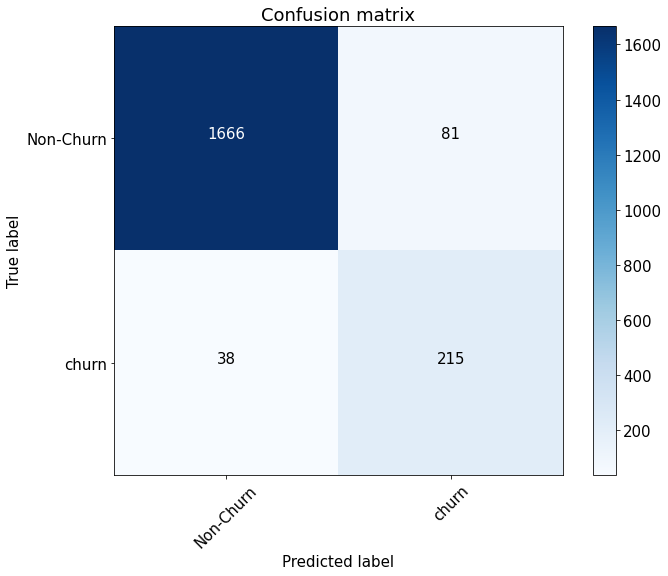

In [201]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [202]:
roc_auc_score(y_test, preds)

0.9741895196961025